# Attention Code and Math Walkthrough

- Time to get really nitty gritty here -> how do i want to handle math and code for attention?
- I think transformer lens could be pretty helpful

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# plt.plot([1,2,3]); #plt.show()

In [3]:
import transformer_lens
import torch.nn as nn
import einops
from jaxtyping import Float, Int
import torch as t
from torch import Tensor
from dataclasses import dataclass

In [4]:
sys.path.append('/home/stephen/deepseek/ARENA_3.0-main/chapter1_transformer_interp/exercises')
import part1_transformer_from_scratch.tests as tests

In [5]:
device='cuda'
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small")

Loaded pretrained model gpt2-small into HookedTransformer


In [6]:
reference_text = "The American flag is red, white, and"

In [7]:
tokens = model.to_tokens(reference_text).to(device)
logits, cache = model.run_with_cache(tokens)
logits.shape

torch.Size([1, 10, 50257])

In [8]:
probs = logits.softmax(dim=-1)
print(probs.shape)

torch.Size([1, 10, 50257])


In [9]:
most_likely_next_tokens = model.tokenizer.batch_decode(logits.argmax(dim=-1)[0])

In [10]:
print(list(zip(model.to_str_tokens(tokens), most_likely_next_tokens)))

[('<|endoftext|>', '\n'), ('The', ' first'), (' American', ' Civil'), (' flag', ' is'), (' is', ' displayed'), (' red', ','), (',', ' white'), (' white', ' and'), (',', ' and'), (' and', ' blue')]


In [11]:
model.blocks[0].attn.W_Q.shape

torch.Size([12, 768, 64])

In [12]:
model.blocks[0].attn.W_K.shape

torch.Size([12, 768, 64])

- Ok, i looked at source doe here - a bit more complicated than I would like
- I should proably follow the tutorial 1.1 solution - just uses more einops than I want, but probably fine.
- I do want to look briefly at deepseek implementation though - I feel like the simplify things pretty nicely!
- Ah yeah Nanda's solution isn't using linear layers, which makes it a bit more complicated -> i see.
- This is a very nice reference to have.
- There's some nice visualizers in there too -> we'll see if it makese sense to use them. 

In [13]:
@dataclass
class Config:
    d_model: int = 768
    debug: bool = True
    layer_norm_eps: float = 1e-5
    d_vocab: int = 50257
    init_range: float = 0.02
    n_ctx: int = 1024
    d_head: int = 64
    d_mlp: int = 3072
    n_heads: int = 12
    n_layers: int = 12


cfg = Config()
print(cfg)

Config(d_model=768, debug=True, layer_norm_eps=1e-05, d_vocab=50257, init_range=0.02, n_ctx=1024, d_head=64, d_mlp=3072, n_heads=12, n_layers=12)


In [14]:
def load_gpt2_test(cls, gpt2_layer, input):
    cfg = Config(debug=True)
    layer = cls(cfg).to(device)
    layer.load_state_dict(gpt2_layer.state_dict(), strict=False)
    print("Input shape:", input.shape)
    output = layer(input)
    if isinstance(output, tuple):
        output = output[0]
    print("Output shape:", output.shape)
    try:
        reference_output = gpt2_layer(input)
    except:
        reference_output = gpt2_layer(input, input, input)
    print("Reference output shape:", reference_output.shape, "\n")
    comparison = t.isclose(output, reference_output, atol=1e-4, rtol=1e-3)
    print(f"{comparison.sum()/comparison.numel():.2%} of the values are correct\n")
    assert 1 - (comparison.sum() / comparison.numel()) < 1e-5, "More than 0.01% of the values are incorrect"

In [15]:
class Attention(nn.Module):
    IGNORE: Float[Tensor, ""]

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_Q = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_K = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_V = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_O = nn.Parameter(t.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        self.b_Q = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_K = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_V = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_O = nn.Parameter(t.zeros((cfg.d_model)))
        nn.init.normal_(self.W_Q, std=self.cfg.init_range)
        nn.init.normal_(self.W_K, std=self.cfg.init_range)
        nn.init.normal_(self.W_V, std=self.cfg.init_range)
        nn.init.normal_(self.W_O, std=self.cfg.init_range)
        self.register_buffer("IGNORE", t.tensor(float("-inf"), dtype=t.float32, device=device))

    def forward(self, normalized_resid_pre: Float[Tensor, "batch posn d_model"]) -> Float[Tensor, "batch posn d_model"]:
        # Calculate query, key and value vectors
        q = (
            einops.einsum(
                normalized_resid_pre, self.W_Q, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
            )
            + self.b_Q
        )
        k = (
            einops.einsum(
                normalized_resid_pre, self.W_K, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
            )
            + self.b_K
        )
        v = (
            einops.einsum(
                normalized_resid_pre, self.W_V, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
            )
            + self.b_V
        )

        # Calculate attention scores, then scale and mask, and apply softmax to get probabilities
        attn_scores = einops.einsum(
            q, k, "batch posn_Q nheads d_head, batch posn_K nheads d_head -> batch nheads posn_Q posn_K"
        )
        attn_scores_masked = self.apply_causal_mask(attn_scores / self.cfg.d_head**0.5)
        attn_pattern = attn_scores_masked.softmax(-1)

        # Take weighted sum of value vectors, according to attention probabilities
        z = einops.einsum(
            v, attn_pattern, "batch posn_K nheads d_head, batch nheads posn_Q posn_K -> batch posn_Q nheads d_head"
        )

        # Calculate output (by applying matrix W_O and summing over heads, then adding bias b_O)
        attn_out = (
            einops.einsum(z, self.W_O, "batch posn_Q nheads d_head, nheads d_head d_model -> batch posn_Q d_model")
            + self.b_O
        )

        return attn_out

    def apply_causal_mask(
        self, attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"]
    ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
        """
        Applies a causal mask to attention scores, and returns masked scores.
        """
        # Define a mask that is True for all positions we want to set probabilities to zero for
        all_ones = t.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device)
        mask = t.triu(all_ones, diagonal=1).bool()
        # Apply the mask to attention scores, then return the masked scores
        attn_scores.masked_fill_(mask, self.IGNORE)
        return attn_scores


# tests.test_causal_mask(Attention.apply_causal_mask)
# rand_float_test(Attention, [2, 4, 768])
load_gpt2_test(Attention, model.blocks[0].attn, cache["normalized", 0, "ln1"])

Input shape: torch.Size([1, 10, 768])
Output shape: torch.Size([1, 10, 768])
Reference output shape: torch.Size([1, 10, 768]) 

100.00% of the values are correct



- Ok great! That unit test is nice as I'm hacking!
- Alright, can I kinda take apart that unit test and get the guts really out here?
- That would be nice -> I would kinda like to replace some or all of those einops with matrix multiplies if I can, and I can add in the equations

## Walk Through Unit Test

In [16]:
cfg = Config(debug=True)

In [17]:
layer = Attention(cfg).to(device)

In [18]:
layer.W_Q[0][:4,:4]

tensor([[-0.0112, -0.0194, -0.0080,  0.0139],
        [ 0.0292,  0.0047, -0.0190, -0.0112],
        [-0.0122,  0.0126, -0.0199, -0.0003],
        [-0.0059, -0.0198,  0.0142, -0.0031]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [19]:
layer.load_state_dict(model.blocks[0].attn.state_dict(), strict=False);

In [20]:
layer.W_Q[0][:4,:4] #Ok cool looks like weights are geting laoded

tensor([[-0.1026, -0.0609, -0.0249, -0.0791],
        [ 0.0191,  0.0242,  0.0404,  0.0515],
        [ 0.0038,  0.0081,  0.0532, -0.0121],
        [ 0.0456, -0.0387, -0.0057,  0.0806]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [21]:
output = layer(cache["normalized", 0, "ln1"])
reference_output = model.blocks[0].attn(cache["normalized", 0, "ln1"], cache["normalized", 0, "ln1"], cache["normalized", 0, "ln1"])

In [22]:
comparison = t.isclose(output, reference_output, atol=1e-4, rtol=1e-3)
print(f"{comparison.sum()/comparison.numel():.2%} of the values are correct\n")
assert 1 - (comparison.sum() / comparison.numel()) < 1e-5, "More than 0.01% of the values are incorrect"

100.00% of the values are correct



## Dope, now pull apart class and work on understanding, mathifying, and replacing piece by piece

In [23]:
W_Q=layer.W_Q 
W_K=layer.W_K
W_V=layer.W_V
W_O=layer.W_O 
b_Q=layer.b_Q
b_K=layer.b_K 
b_V=layer.b_V 
b_O=layer.b_O

In [24]:
W_Q[0][:4,:4] 

tensor([[-0.1026, -0.0609, -0.0249, -0.0791],
        [ 0.0191,  0.0242,  0.0404,  0.0515],
        [ 0.0038,  0.0081,  0.0532, -0.0121],
        [ 0.0456, -0.0387, -0.0057,  0.0806]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [25]:
W_Q.shape, W_K.shape, W_V.shape, W_O.shape

(torch.Size([12, 768, 64]),
 torch.Size([12, 768, 64]),
 torch.Size([12, 768, 64]),
 torch.Size([12, 64, 768]))

In [26]:
b_Q.shape, b_K.shape, b_V.shape, b_O.shape

(torch.Size([12, 64]),
 torch.Size([12, 64]),
 torch.Size([12, 64]),
 torch.Size([768]))

Cool, that's easy

In [27]:
normalized_resid_pre=cache["normalized", 0, "ln1"]

Hmm a little tricky but I think good to think through the code and math here!

In [29]:
cfg

Config(d_model=768, debug=True, layer_norm_eps=1e-05, d_vocab=50257, init_range=0.02, n_ctx=1024, d_head=64, d_mlp=3072, n_heads=12, n_layers=12)

### Compute Queries
- Deepseek math is doing this kinda one token at a time instead of one head at a time?
- Ok at this point I think some version of the mat like this makes the most sense to me:
$$
q_{l,h}=W_{l,h}^Q h + b_{l,h}
$$
- I can merge and break things apart as needed of course - probably will end up merging this accross heads, but for now this is ok!
- So this is hos we compute the queries at a given layer $l$ and attention head $h$
- Dimensions: 


In [68]:
normalized_resid_pre.shape, W_Q.shape, b_Q.shape

(torch.Size([1, 10, 768]), torch.Size([12, 768, 64]), torch.Size([12, 64]))

In [76]:
#There's more efficient ways to do this -> but this is one matrix multiply per head 
qs=[]
for head_num in range(cfg.n_heads):
    qs.append((W_Q[head_num].T @ normalized_resid_pre[0].T).T +b_Q[head_num]) 

Ok, all this transposing is pretty silly - if I want my matrix multiply to be on the left, which I think I do, I'll transpose the dimension of my weights and biases from the beginning.

In [77]:
qs[0].shape

torch.Size([10, 64])

In [78]:
q=t.stack(qs, dim=0).unsqueeze(0).permute(0, 2, 1, 3) #Stack results together, add batch dimension, switch token and head dims.

In [79]:
q.shape

torch.Size([1, 10, 12, 64])

In [80]:
# q = (
#     einops.einsum(
#         normalized_resid_pre, W_Q, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
#     )
#     + b_Q
# )

In [81]:
q.shape

torch.Size([1, 10, 12, 64])

### Compute Keys
- Can do same as above to break down computation for keys and values. 
$$
k_{l,h}=W_{l,h}^K h + b_{l,h}
$$

In [98]:
k = (
    einops.einsum(
        normalized_resid_pre, W_K, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
    )
    + b_K
)

In [83]:
k.shape

torch.Size([1, 10, 12, 64])

### Compute Values
- Can do same as above to break down computation for keys and values. 
$$
v_{l,h}=W_{l,h}^V h + b_{l,h}
$$

In [84]:
v = (
    einops.einsum(
        normalized_resid_pre, W_V, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
    )
    + b_V
)

In [85]:
v.shape

torch.Size([1, 10, 12, 64])

## Compute attention scores

$$
A_{l,h}=Softmax \bigg( \frac{q_{l,h}k_{l,h}^T}{\sqrt{d}} \bigg)
$$

In [99]:
# Calculate attention scores, then scale and mask, and apply softmax to get probabilities
attn_scores = einops.einsum(
    q, k, "batch posn_Q nheads d_head, batch posn_K nheads d_head -> batch nheads posn_Q posn_K"
)

In [100]:
attn_scores.shape

torch.Size([1, 12, 10, 10])

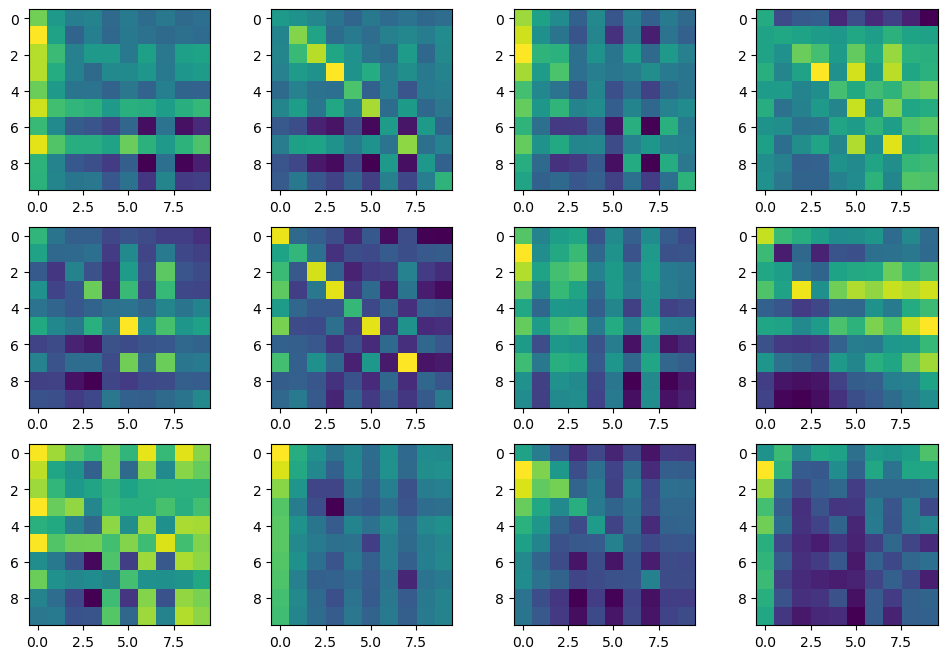

In [101]:
fig=figure(0,(12,8))
for i in range(12):
    fig.add_subplot(3,4,i+1)
    plt.imshow(attn_scores[0,i].detach().cpu().numpy())
plt.show()

Woah i feel like there's a lot going on here!

In [102]:
attn_scores_masked = layer.apply_causal_mask(attn_scores / layer.cfg.d_head**0.5)

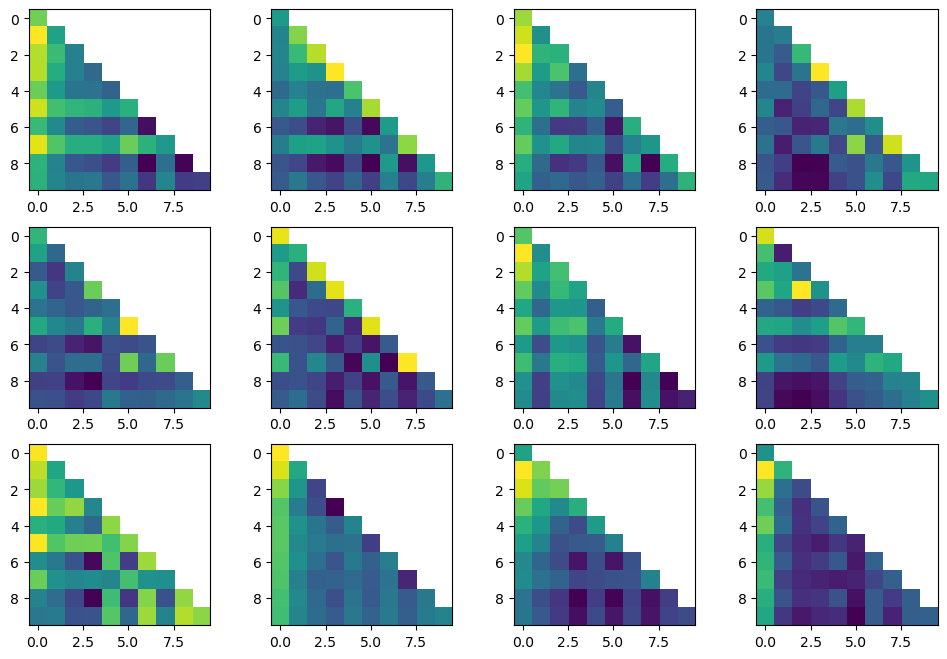

In [103]:
fig=figure(0,(12,8))
for i in range(12):
    fig.add_subplot(3,4,i+1)
    plt.imshow(attn_scores_masked[0,i].detach().cpu().numpy())
plt.show()

In [104]:
attn_pattern = attn_scores_masked.softmax(-1)

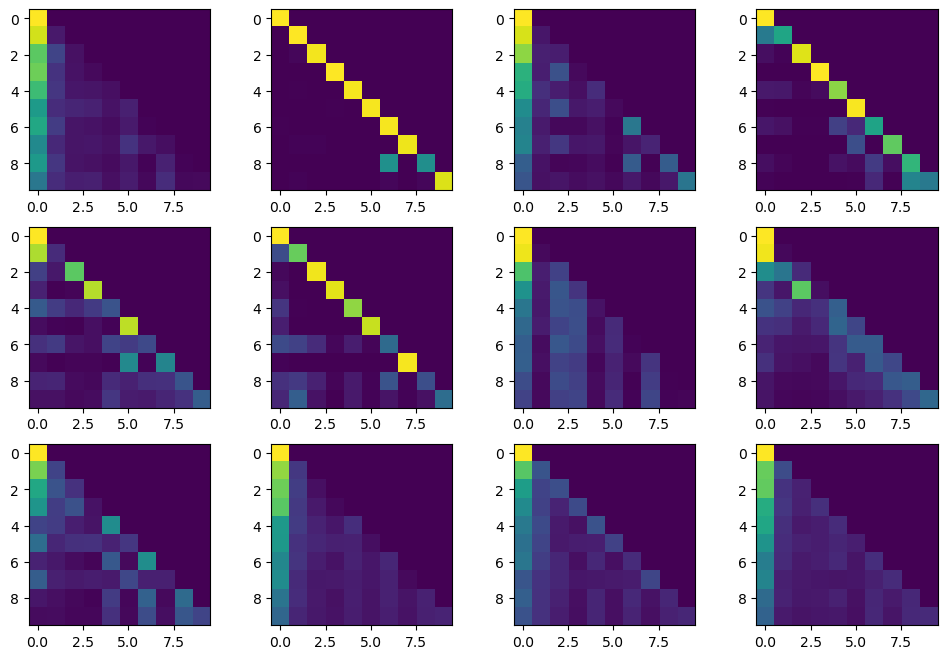

In [105]:
fig=figure(0,(12,8))
for i in range(12):
    fig.add_subplot(3,4,i+1)
    plt.imshow(attn_pattern[0,i].detach().cpu().numpy())
plt.show()

In [109]:
attn_pattern[0,0] #Rows add to 1. 

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9330, 0.0670, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.7491, 0.2068, 0.0442, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.7812, 0.1447, 0.0475, 0.0265, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.6851, 0.1575, 0.0598, 0.0582, 0.0395, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.5437, 0.1283, 0.1017, 0.0908, 0.0489, 0.0865, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.5996, 0.1790, 0.0574, 0.0476, 0.0337, 0.0712, 0.0115, 0.0000, 0.0000,
         0.0000],
        [0.4764, 0.1139, 0.0582, 0.0592, 0.0441, 0.1467, 0.0664, 0.0352, 0.0000,
         0.0000],
        [0.5410, 0.1568, 0.0529, 0.0440, 0.0291, 0.0629, 0.0097, 0.0933, 0.0103,
         0.0000],
        [0.3955, 0.1258, 0.0823, 0.0881, 0.0395, 0.0772, 0.0202, 0.1259, 0.0217,
         0.0239]], device='c

Dope

## Ouput
- Ok, this part is confusing me, because I thought it was one step
- Wait actually no it is 2 steps?
- Erm, we have the values, and we have the attention pattern -> i guess the last step is kinda that "bring evertything back together step?

In [111]:
v.shape, attn_pattern.shape

(torch.Size([1, 10, 12, 64]), torch.Size([1, 12, 10, 10]))

In [106]:
# Take weighted sum of value vectors, according to attention probabilities
# z = einops.einsum(
#     v, attn_pattern, "batch posn_K nheads d_head, batch nheads posn_Q posn_K -> batch posn_Q nheads d_head"
# )

$$
o_{l, h}=A_{l,h}v_{l,h}
$$

In [118]:
zs=[]
for head_num in range(cfg.n_heads):
    zs.append(attn_pattern[0, head_num, :, :] @ v[0, :, head_num, :])

In [119]:
zs[0].shape

torch.Size([10, 64])

In [120]:
z=t.stack(zs, dim=0).unsqueeze(0).permute(0, 2, 1, 3) #

In [121]:
z.shape

torch.Size([1, 10, 12, 64])

In [122]:
z.shape

torch.Size([1, 10, 12, 64])

In [125]:
W_O.shape, b_O.shape

(torch.Size([12, 64, 768]), torch.Size([768]))

In [95]:
# Calculate output (by applying matrix W_O and summing over heads, then adding bias b_O)
attn_out = (
    einops.einsum(z, W_O, "batch posn_Q nheads d_head, nheads d_head d_model -> batch posn_Q d_model")
    + b_O
)

- Hmm this is a little trickier dimension wise.
- I thought that W_O would support a concatenation step first -> maybe it does in the deepseek implementation -> not sure yet
- Like where are the 12 heads getting added back together
- Ok I guess it it is there actually, W_0 is just very much not arranged like it would be in a Linear layer -eh?

In [137]:
attn_out=((W_O.reshape(-1, 768).T @ z[0].reshape(10, -1).T).T+b_O).unsqueeze(0) 

In [138]:
attn_out.shape

torch.Size([1, 10, 768])

In [139]:
attn_out.shape

torch.Size([1, 10, 768])

In [140]:
reference_output = model.blocks[0].attn(cache["normalized", 0, "ln1"], cache["normalized", 0, "ln1"], cache["normalized", 0, "ln1"])

comparison = t.isclose(attn_out, reference_output, atol=1e-4, rtol=1e-3)
print(f"{comparison.sum()/comparison.numel():.2%} of the values are correct\n")
assert 1 - (comparison.sum() / comparison.numel()) < 1e-5, "More than 0.01% of the values are incorrect"

100.00% of the values are correct



$$
o_{l, h}=A_{l,h}v_{l,h}
$$
$$
u_{l} = W_{l}^O o_{l,h} + b_O <- close, not quite
$$

Ok yea so something like is close, but i need to either express the fact we're summing across heads with a concatenation then a big mulitply, or with a summation. Concatenation and big multiply is probably more intuitive, but depends a lot on how I want to end up explaining stuff. So something like...

$$
u_{l} = W_{l}^O [o_{l,0};o_{l,1};...;o_{l,n_h}] + b_O
$$

I don't like $u$ as the final output variable, will need to workshop it a bit.

Ok but yeah I feel like that's a decent first pass through the math, will adjust as I figure out how I want to juxtopose this with MLA> 

## Now visualize all 144 patterns and look for examples i can use?
- Would be cool to find one where American modifies Flag, and one where Red and white modify the answer. 

In [155]:
token_string_list=model.to_str_tokens(tokens)

In [157]:
token_string_list

['<|endoftext|>',
 'The',
 ' American',
 ' flag',
 ' is',
 ' red',
 ',',
 ' white',
 ',',
 ' and']

In [150]:
attn_pattern=cache['blocks.1.attn.hook_pattern']

In [151]:
attn_pattern.shape

torch.Size([1, 12, 10, 10])

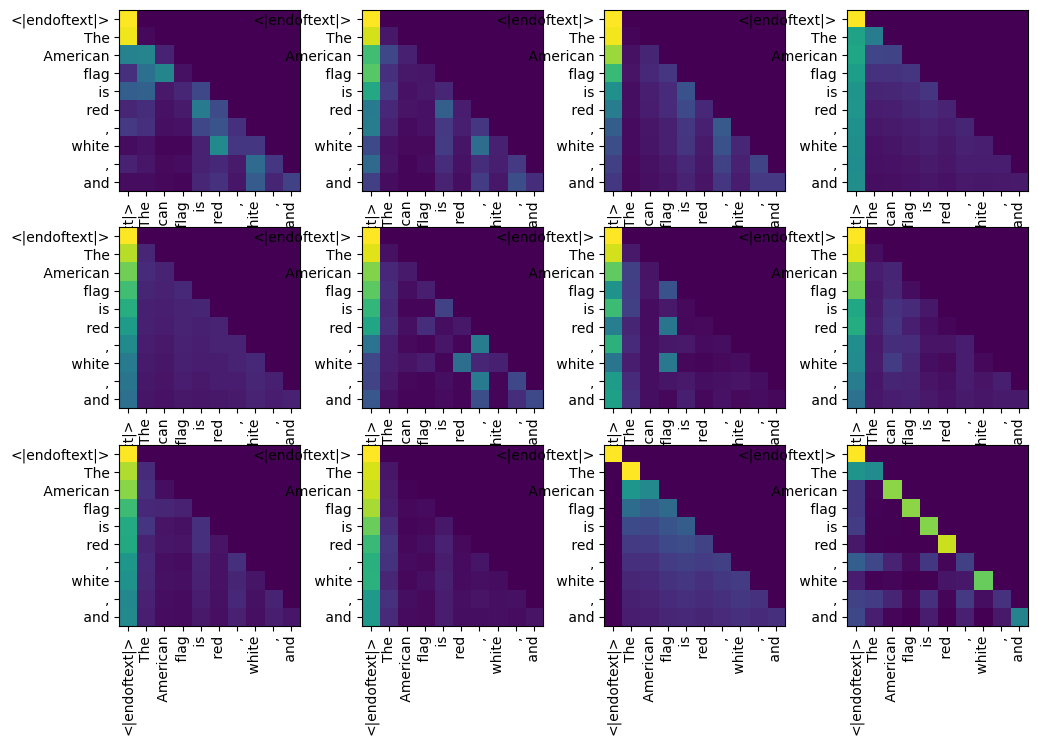

In [161]:
fig=figure(0,(12,8))
for i in range(12):
    ax=fig.add_subplot(3,4,i+1)
    plt.imshow(attn_pattern[0,i].detach().cpu().numpy())
    ax.set_xticks(np.arange(len(token_string_list)))
    ax.set_xticklabels(token_string_list)
    plt.xticks(rotation=90)
    ax.set_yticks(np.arange(len(token_string_list)))
    ax.set_yticklabels(token_string_list)
plt.show()

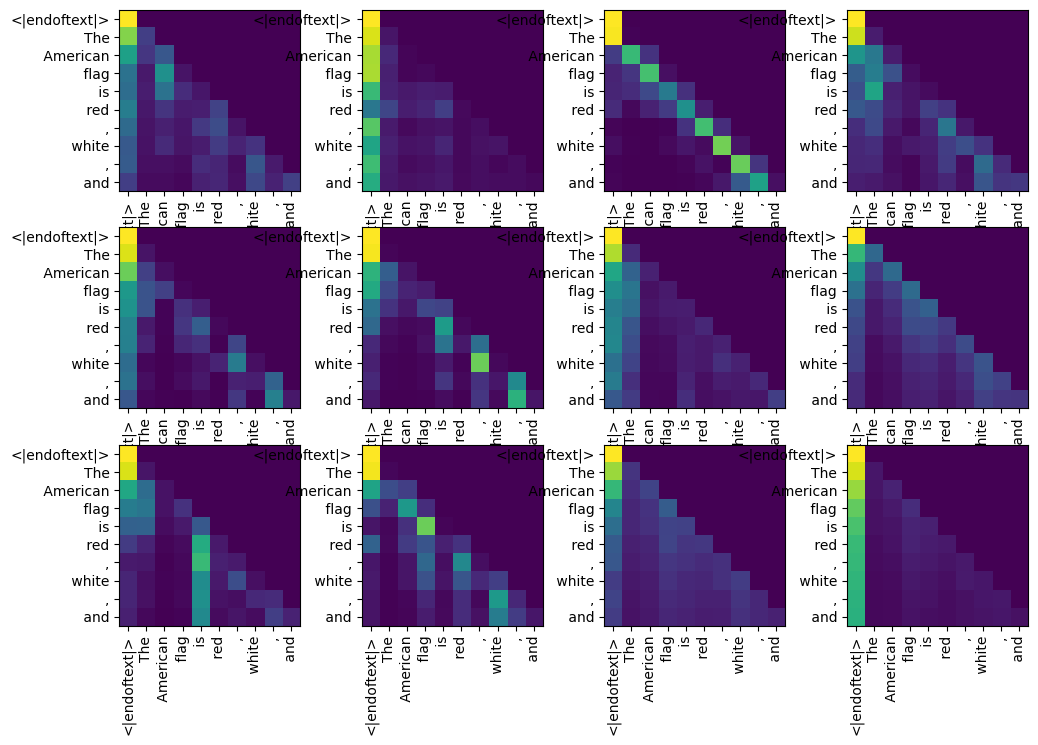

In [162]:
attn_pattern=cache['blocks.2.attn.hook_pattern']
fig=figure(0,(12,8))
for i in range(12):
    ax=fig.add_subplot(3,4,i+1)
    plt.imshow(attn_pattern[0,i].detach().cpu().numpy())
    ax.set_xticks(np.arange(len(token_string_list)))
    ax.set_xticklabels(token_string_list)
    plt.xticks(rotation=90)
    ax.set_yticks(np.arange(len(token_string_list)))
    ax.set_yticklabels(token_string_list)
plt.show()

Layer 2, head 10 is a good candidate for american modifying flag. 
Looks like there's a head looking at commas - that's cool. 

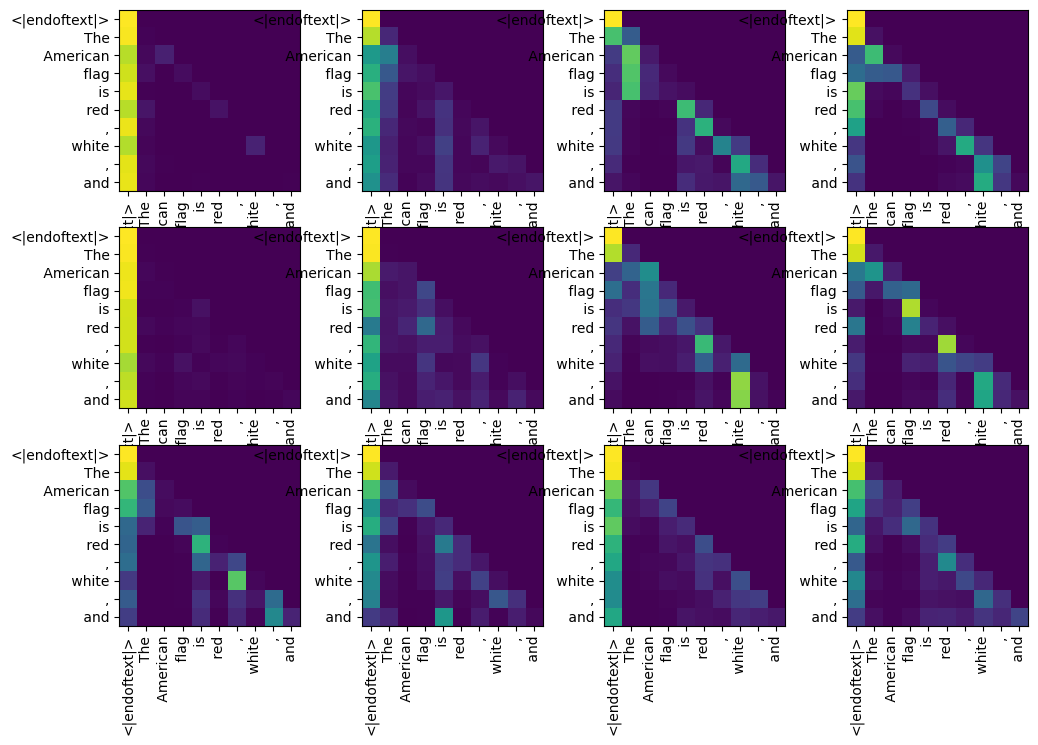

In [163]:
attn_pattern=cache['blocks.3.attn.hook_pattern']
fig=figure(0,(12,8))
for i in range(12):
    ax=fig.add_subplot(3,4,i+1)
    plt.imshow(attn_pattern[0,i].detach().cpu().numpy())
    ax.set_xticks(np.arange(len(token_string_list)))
    ax.set_xticklabels(token_string_list)
    plt.xticks(rotation=90)
    ax.set_yticks(np.arange(len(token_string_list)))
    ax.set_yticklabels(token_string_list)
plt.show()

Ok i think head 7 here could be a good red and white cnadidate. 

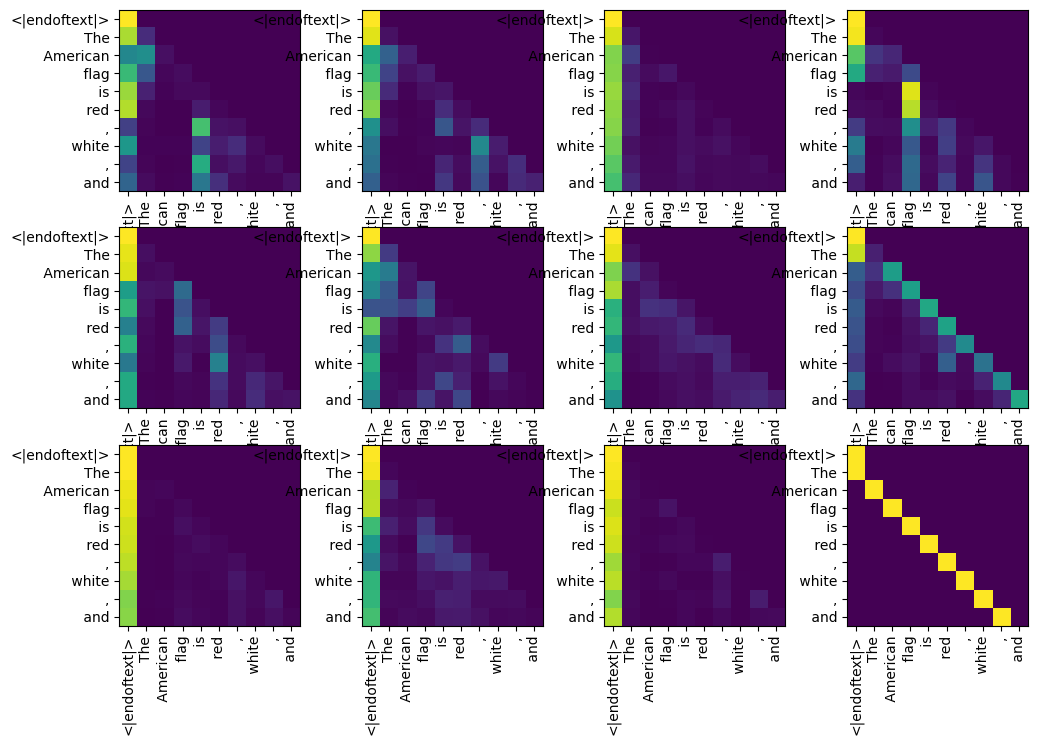

In [164]:
attn_pattern=cache['blocks.4.attn.hook_pattern']
fig=figure(0,(12,8))
for i in range(12):
    ax=fig.add_subplot(3,4,i+1)
    plt.imshow(attn_pattern[0,i].detach().cpu().numpy())
    ax.set_xticks(np.arange(len(token_string_list)))
    ax.set_xticklabels(token_string_list)
    plt.xticks(rotation=90)
    ax.set_yticks(np.arange(len(token_string_list)))
    ax.set_yticklabels(token_string_list)
plt.show()

- Flag red and white on head 4
- Tempted to leave out first column.

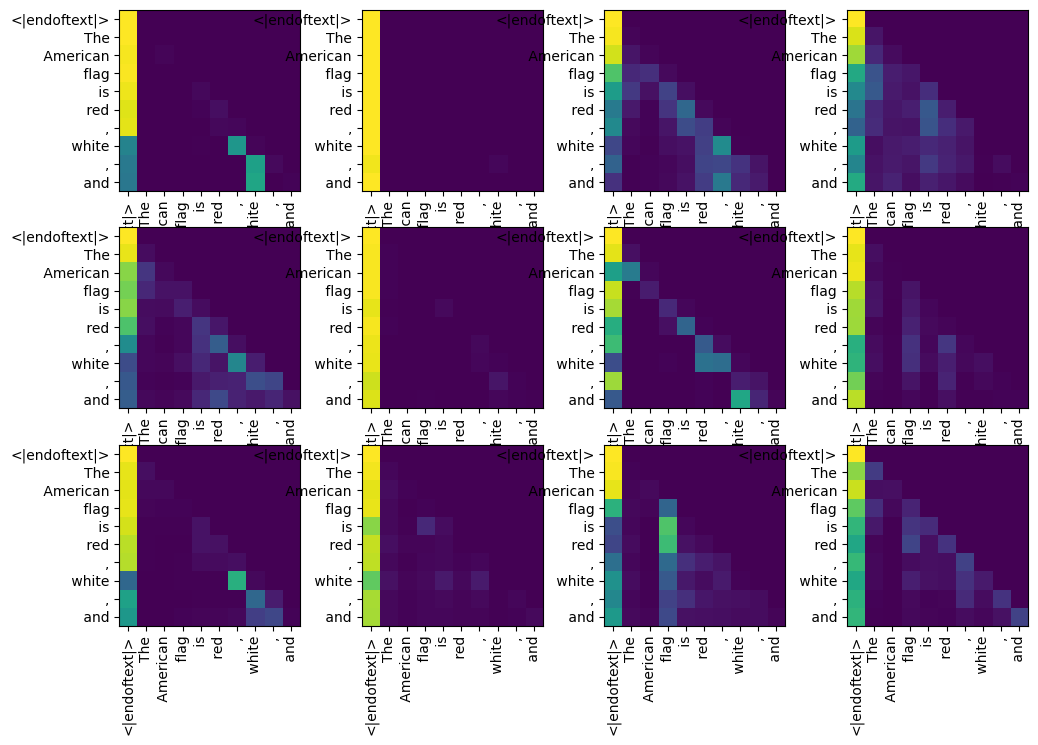

In [165]:
attn_pattern=cache['blocks.5.attn.hook_pattern']
fig=figure(0,(12,8))
for i in range(12):
    ax=fig.add_subplot(3,4,i+1)
    plt.imshow(attn_pattern[0,i].detach().cpu().numpy())
    ax.set_xticks(np.arange(len(token_string_list)))
    ax.set_xticklabels(token_string_list)
    plt.xticks(rotation=90)
    ax.set_yticks(np.arange(len(token_string_list)))
    ax.set_yticklabels(token_string_list)
plt.show()

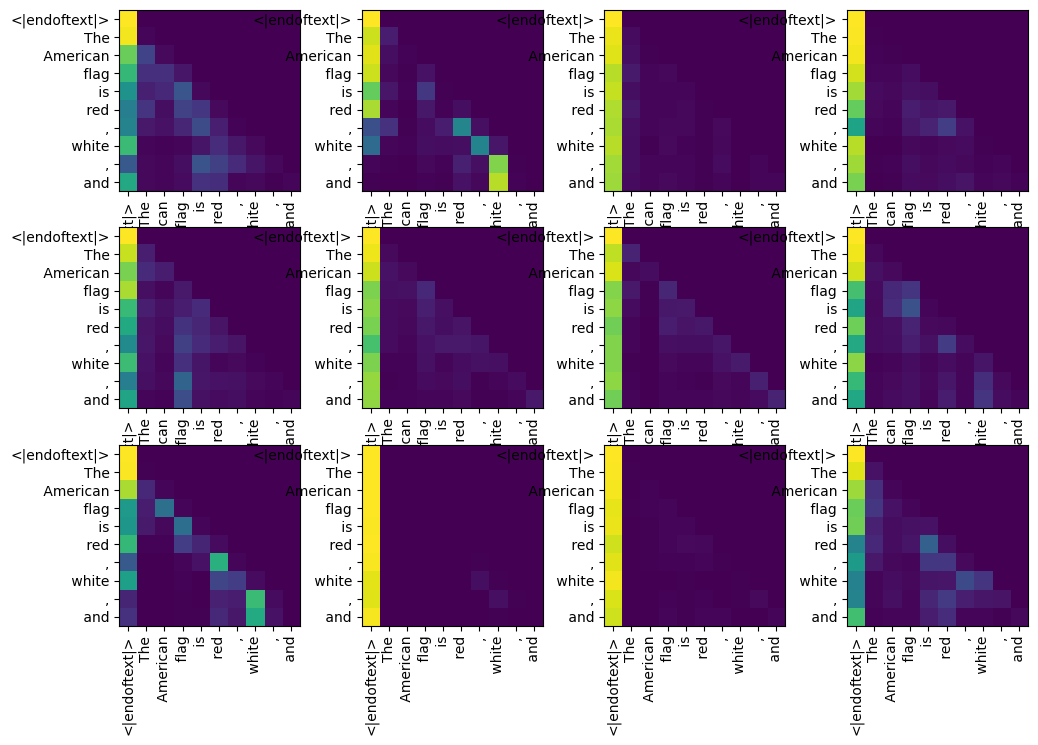

In [166]:
attn_pattern=cache['blocks.6.attn.hook_pattern']
fig=figure(0,(12,8))
for i in range(12):
    ax=fig.add_subplot(3,4,i+1)
    plt.imshow(attn_pattern[0,i].detach().cpu().numpy())
    ax.set_xticks(np.arange(len(token_string_list)))
    ax.set_xticklabels(token_string_list)
    plt.xticks(rotation=90)
    ax.set_yticks(np.arange(len(token_string_list)))
    ax.set_yticklabels(token_string_list)
plt.show()

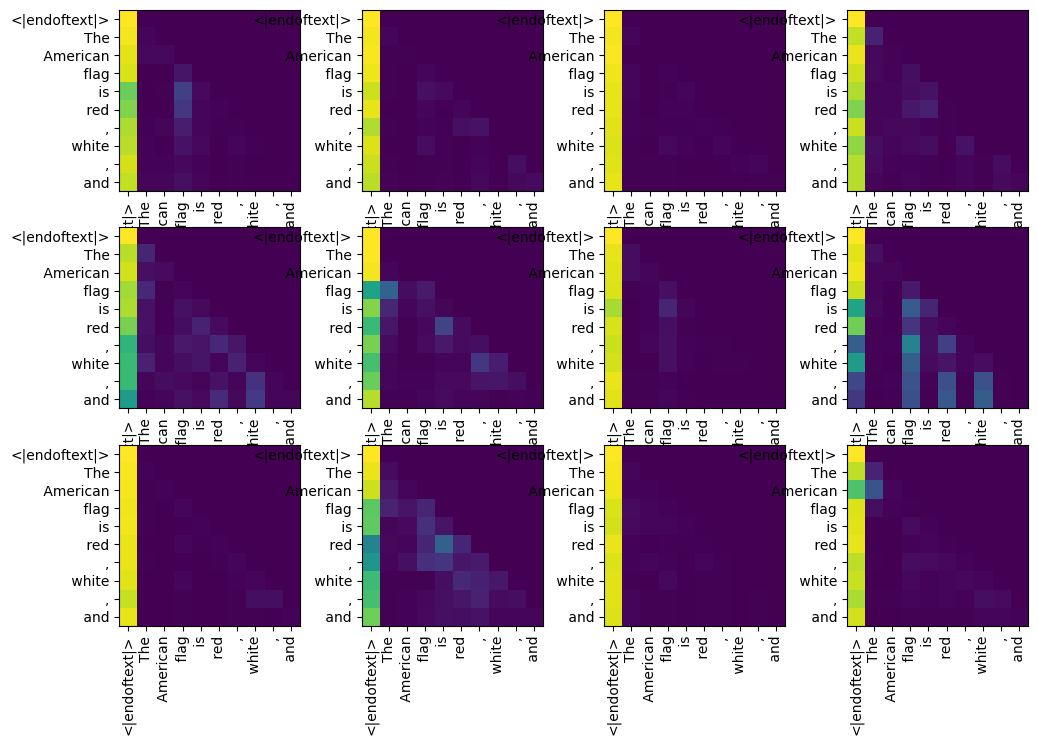

In [170]:
attn_pattern=cache['blocks.10.attn.hook_pattern']
fig=figure(0,(12,8))
for i in range(12):
    ax=fig.add_subplot(3,4,i+1)
    plt.imshow(attn_pattern[0,i].detach().cpu().numpy())
    ax.set_xticks(np.arange(len(token_string_list)))
    ax.set_xticklabels(token_string_list)
    plt.xticks(rotation=90)
    ax.set_yticks(np.arange(len(token_string_list)))
    ax.set_yticklabels(token_string_list)
plt.show()

Flag, read and white on 8

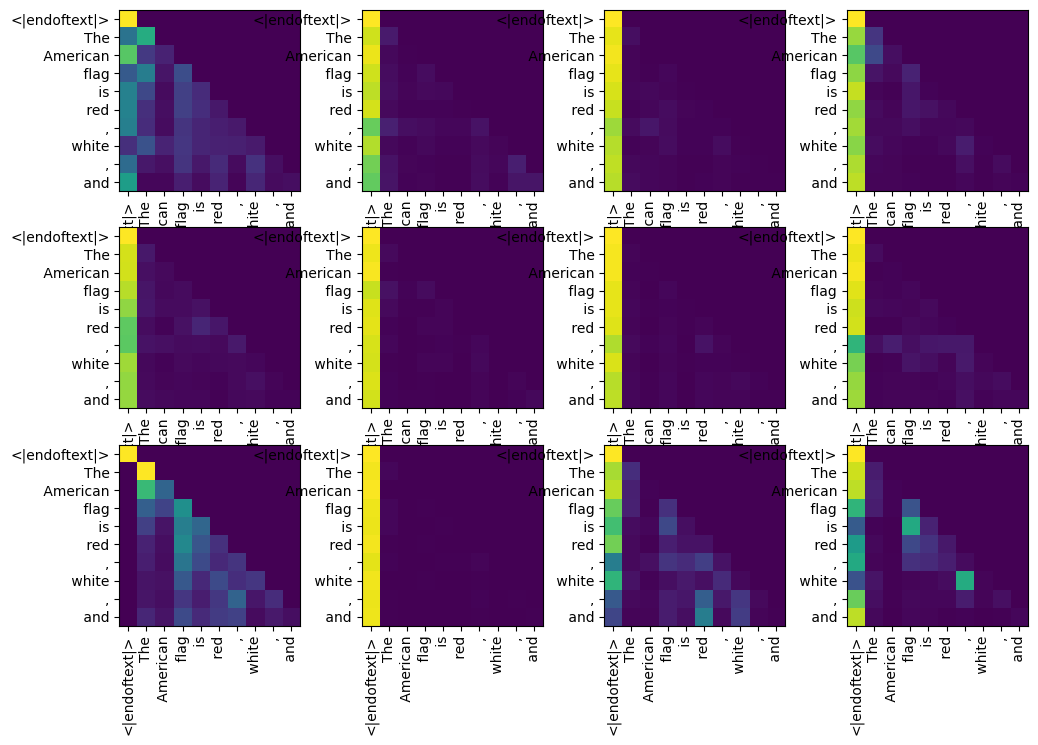

In [171]:
attn_pattern=cache['blocks.11.attn.hook_pattern']
fig=figure(0,(12,8))
for i in range(12):
    ax=fig.add_subplot(3,4,i+1)
    plt.imshow(attn_pattern[0,i].detach().cpu().numpy())
    ax.set_xticks(np.arange(len(token_string_list)))
    ax.set_xticklabels(token_string_list)
    plt.xticks(rotation=90)
    ax.set_yticks(np.arange(len(token_string_list)))
    ax.set_yticklabels(token_string_list)
plt.show()

Cool yeah I think this could work pretty well. 

In [143]:
cache.keys()

dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_pre', 'block